In [1]:
from util._io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np

import fastsca

import _dcpnmf
np.random.seed(42)

import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc
import _topics_util


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sca = fastsca.FASTSCA()
sca.config = args
sca.initdata()
fn = sca.config.home + sca.config.experiment +sca.config.output + sca.config.sample_id+'/'+sca.config.sample_id

In [12]:
df_bd = pd.read_csv(fn+'_model_depth.csv.gz')
df_bf = pd.read_csv(fn+'_model_freq.csv.gz')
df_bbeta = pd.read_csv(fn+'_model_beta.csv.gz')
df_btheta = pd.read_csv(fn+'_model_theta.csv.gz')

df_scd = pd.read_csv(fn+'_sc_model_depth.csv.gz')
df_scf = pd.read_csv(fn+'_sc_model_freq.csv.gz')
df_scbeta = pd.read_csv(fn+'_sc_model_beta.csv.gz')
df_sctheta = pd.read_csv(fn+'_sc_model_theta.csv.gz')
df_btheta = df_btheta.rename(columns={'Unnamed: 0':'cell'})
df_bbeta = df_bbeta.rename(columns={'Unnamed: 0':'topic'})
df_sctheta = df_sctheta.rename(columns={'Unnamed: 0':'cell'})
df_scbeta = df_scbeta.rename(columns={'Unnamed: 0':'topic'})

df_bulk_trace= pd.read_csv(fn+'_model_bulk_trace.csv.gz')
df_sc_trace = pd.read_csv(fn+'_sc_model_bulk_trace.csv.gz')
df_scbulk_trace = pd.read_csv(fn+'_model_sc_trace.csv.gz')


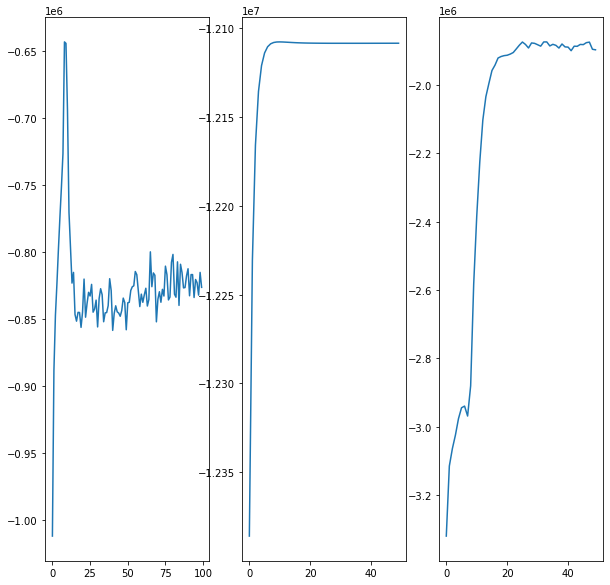

In [13]:
figure,axis = plt.subplots(1,3)
axis[0].plot(df_bulk_trace.iloc[:,1].values)
axis[1].plot(df_scbulk_trace.iloc[:,1].values)
axis[2].plot(df_sc_trace.iloc[:,1].values)

In [14]:
df_pl = pd.read_csv(sca.config.home + sca.config.experiment +sca.config.output + sca.config.sample_id+'/'+sca.config.sample_id+'_prior_label.csv.gz')
df_pl

,cell,label,umap1,umap2,cell_type
0,AAACATACAACCAC-1,0,8.927887,3.253341,CD4
1,AAACATTGAGCTAC-1,2,7.016333,10.311687,B
2,AAACATTGATCAGC-1,0,10.921963,4.996583,CD4
3,AAACCGTGCTTCCG-1,1,-1.403201,4.500485,CD14
4,AAACCGTGTATGCG-1,5,11.737618,-1.013121,NK
...,...,...,...,...,...
2690,TTTCGAACTCTCAT-1,1,0.464932,6.255583,CD14
2691,TTTCTACTGAGGCA-1,2,6.952725,10.245164,B
2692,TTTCTACTTCCTCG-1,2,5.122360,9.857081,B
2693,TTTGCATGAGAGGC-1,2,5.292380,11.635183,B


In [15]:
import umap

df_umap= pd.DataFrame()
df_umap['cell'] = df_sctheta['cell']
df_umap['topic_sc'] = [x for x in df_sctheta.iloc[:,1:].idxmax(axis=1)]
df_umap['topic_bulk'] = [x for x in df_btheta.iloc[:,1:].idxmax(axis=1)]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.0,metric='cosine')
proj_2d = umap_2d.fit(df_sctheta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

# df_umap = pd.read_csv(sca.config.home + sca.config.experiment +sca.config.output + sca.config.sample_id+'/'+sca.config.sample_id+'_sc_umap.csv')
# df_umap = df_umap.rename(columns={'Unnamed: 0':'cell','V1':'umap1','V2':'umap2'})
# df_umap['topic_sc'] = [x for x in df_sctheta.iloc[:,1:].idxmax(axis=1)]
# df_umap['topic_bulk'] = [x for x in df_btheta.iloc[:,1:].idxmax(axis=1)]

# df_umap

,cell,topic_sc,topic_bulk,umap1,umap2
0,AAACATACAACCAC-1,1,9,0.487771,0.764906
1,AAACATTGAGCTAC-1,4,7,14.359407,15.071018
2,AAACATTGATCAGC-1,7,1,1.544429,4.812028
3,AAACCGTGCTTCCG-1,5,5,8.209918,13.732192
4,AAACCGTGTATGCG-1,6,3,1.246282,7.111866
...,...,...,...,...,...
2695,TTTCGAACTCTCAT-1,5,5,8.399383,13.962453
2696,TTTCTACTGAGGCA-1,3,3,-0.377779,5.763446
2697,TTTCTACTTCCTCG-1,4,7,14.593322,12.028111
2698,TTTGCATGAGAGGC-1,4,7,11.955200,15.169112


In [16]:
df_umap = pd.merge(df_umap,df_pl[['cell','cell_type']],on='cell',how='left')
df_umap = df_umap[~df_umap['cell_type'].isna()]
df_umap

,cell,topic_sc,topic_bulk,umap1,umap2,cell_type
0,AAACATACAACCAC-1,1,9,0.487771,0.764906,CD4
1,AAACATTGAGCTAC-1,4,7,14.359407,15.071018,B
2,AAACATTGATCAGC-1,7,1,1.544429,4.812028,CD4
3,AAACCGTGCTTCCG-1,5,5,8.209918,13.732192,CD14
4,AAACCGTGTATGCG-1,6,3,1.246282,7.111866,NK
...,...,...,...,...,...,...
2695,TTTCGAACTCTCAT-1,5,5,8.399383,13.962453,CD14
2696,TTTCTACTGAGGCA-1,3,3,-0.377779,5.763446,B
2697,TTTCTACTTCCTCG-1,4,7,14.593322,12.028111,B
2698,TTTGCATGAGAGGC-1,4,7,11.955200,15.169112,B


In [17]:
df_umap.cell_type.value_counts()

CD4       1135
CD14       486
B          347
CD8        344
FCG        164
NK         161
Dend        36
Megak       13
others       9
Name: cell_type, dtype: int64

Text(0.5, 1.0, 'bulkNMF')

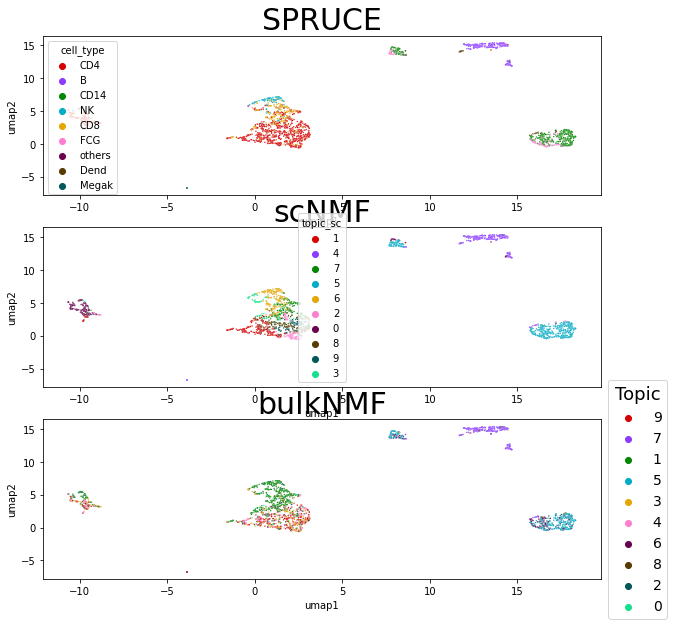

In [18]:


figure,axis = plt.subplots(3,1)
plt.rcParams["figure.figsize"] = (10,10)


cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['cell_type'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='cell_type',s=2,palette=cp,legend=True,ax=axis[0])
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("SPRUCE",fontsize=30)


cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_sc'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_sc',s=2,palette=cp,legend=True,ax=axis[1])
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("scNMF",fontsize=30)

cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=2,palette=cp,legend=True,ax=axis[2])
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("bulkNMF",fontsize=30)


Text(69.0, 0.5, 'bulk')

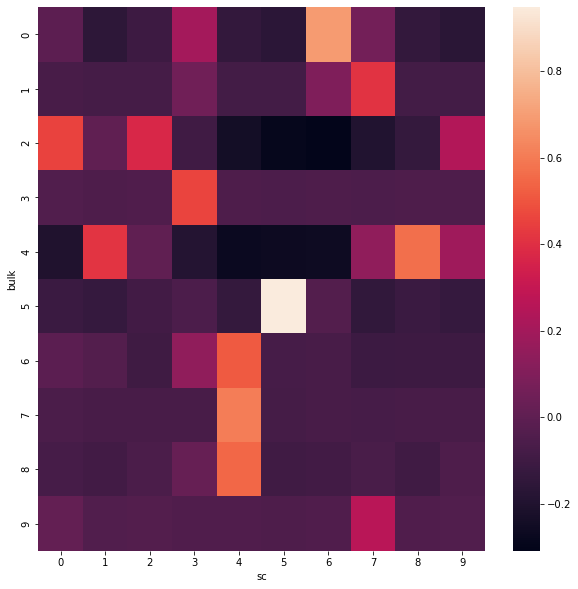

In [19]:
sel_top_genes = list(np.unique(_topics_util.get_topic_top_genes(df_scbeta.iloc[:,1:],top_n=10)['Gene'].values))
K=10
corr=[]
for i in range(K):
    cr = []
    for j in range(K):
        cr.append(np.corrcoef(df_bbeta.loc[i,sel_top_genes],df_scbeta.loc[j,sel_top_genes])[0,1])
    corr.append(cr)
sns.heatmap(corr)
plt.xlabel('sc')
plt.ylabel('bulk')

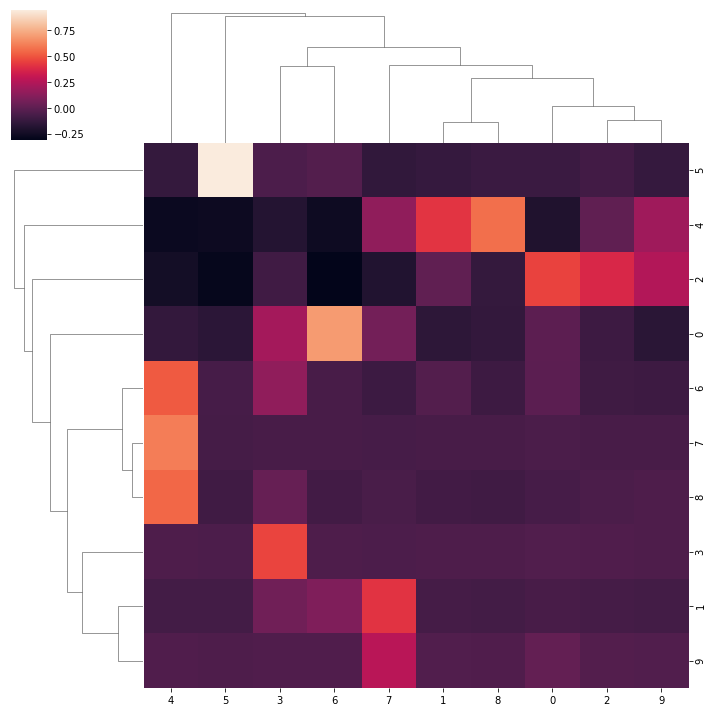

In [20]:
sns.clustermap(corr)

Text(69.0, 0.5, 'bulk')

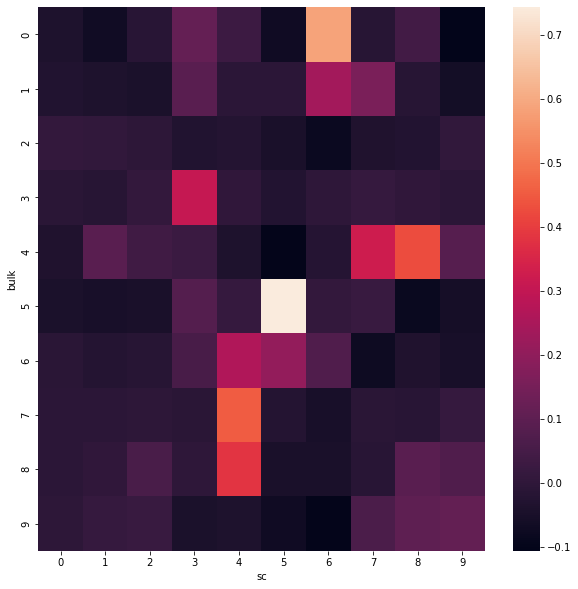

In [21]:
corr=[]
for i in range(K):
    cr = []
    for j in range(K):
        cr.append(np.corrcoef(df_bbeta.iloc[i,1:],df_scbeta.iloc[j,1:])[0,1])
    corr.append(cr)
sns.heatmap(corr)
plt.xlabel('sc')
plt.ylabel('bulk')

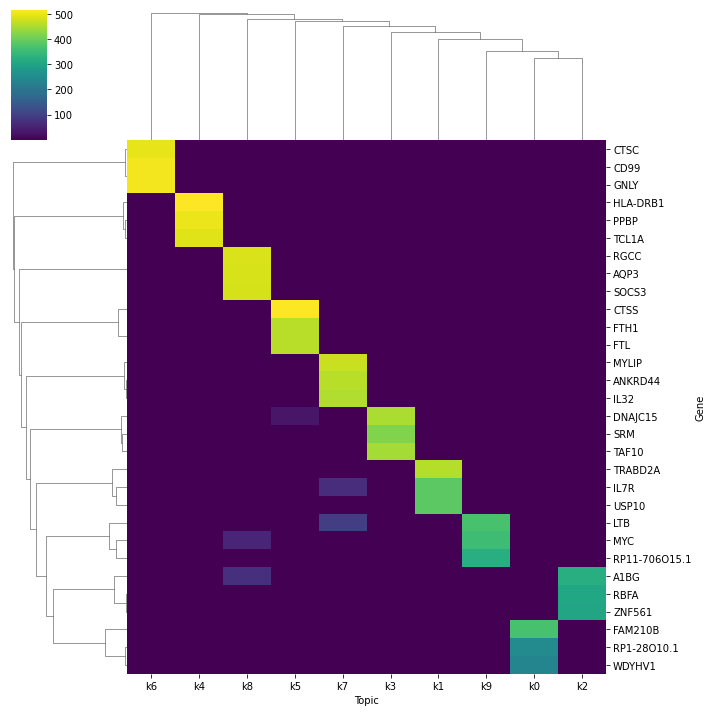

In [22]:
df_top = _topics_util.get_topic_top_genes(df_scbeta,top_n=3)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
sns.clustermap(df_top.T,cmap='viridis')

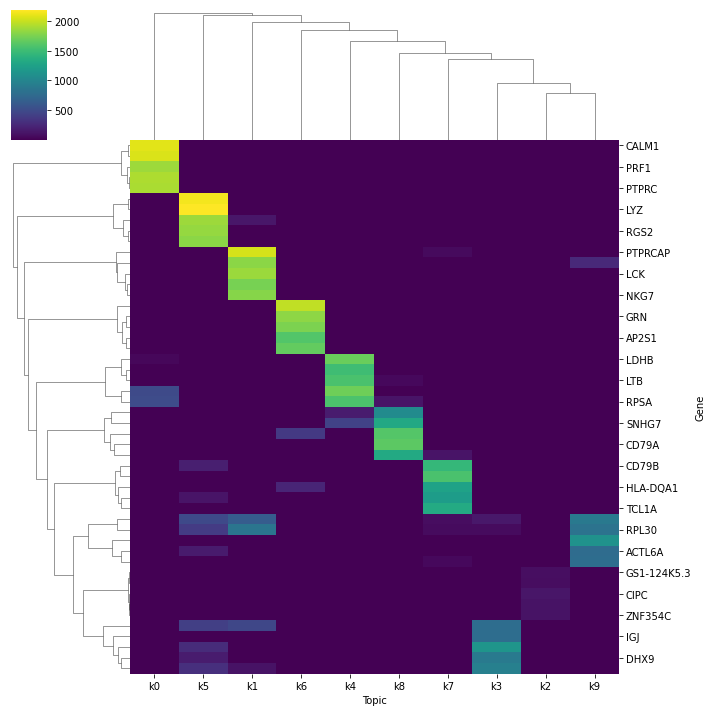

In [23]:
df_top = _topics_util.get_topic_top_genes(df_bbeta,top_n=5)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
sns.clustermap(df_top.T,cmap='viridis')

Text(69.0, 0.5, 'bulk')

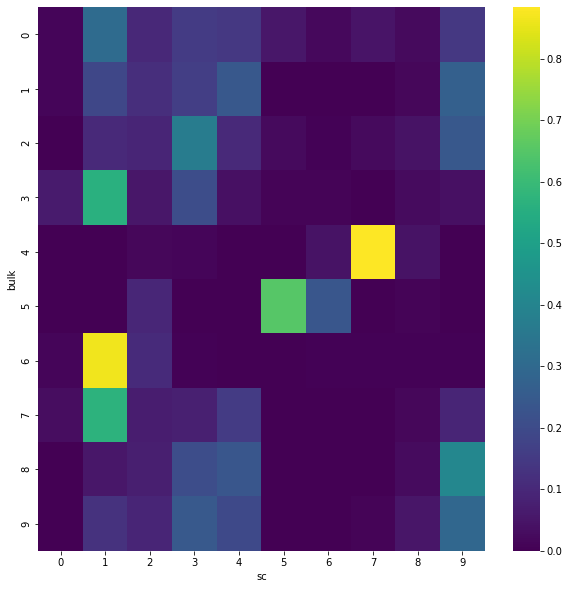

In [24]:
from sklearn.metrics.cluster import contingency_matrix
df_rmatch = pd.DataFrame(contingency_matrix(df_umap.topic_sc,df_umap.topic_bulk))
# df_rmatch = pd.DataFrame(contingency_matrix(df_umap.topic_sc_ct,df_umap.topic_blk_ct))
df_rmatch = df_rmatch.div(df_rmatch.sum(axis=1), axis=0)
sns.heatmap(df_rmatch,cmap='viridis')
plt.xlabel('sc')
plt.ylabel('bulk')


In [24]:
df_grp = df_umap.groupby(['topic_sc','cell_type'])['cell_type'].size().rename('count').reset_index()
celltype_sum = dict(df_grp.groupby('topic_sc')['count'].sum())
df_grp['ncount'] = [x/celltype_sum[y] for x,y in zip(df_grp['count'],df_grp['topic_sc'])]
df_grp = df_grp.rename(columns={'topic_sc':'topic'})
df_grp['topic'] =  df_grp['topic'].astype(int)
df_grp.to_csv(fn+'_r1_topic_sc_ct_dist.csv.gz',index=False, compression='gzip')

df_grp = df_umap.groupby(['topic_bulk','cell_type'])['cell_type'].size().rename('count').reset_index()
celltype_sum = dict(df_grp.groupby('topic_bulk')['count'].sum())
df_grp['ncount'] = [x/celltype_sum[y] for x,y in zip(df_grp['count'],df_grp['topic_bulk'])]
df_grp = df_grp.rename(columns={'topic_bulk':'topic'})
df_grp['topic'] =  df_grp['topic'].astype(int)

bulk_to_sc={
0:4,
1:2,
2:8,
3:3,
4:7,
5:6,
6:0,
7:9,
8:1,
9:5
}

df_grp['topic'] = [bulk_to_sc[x] for x in df_grp['topic']]
df_grp.to_csv(fn+'_r1_topic_bulk_ct_dist.csv.gz',index=False, compression='gzip')


In [50]:
df_grp

,topic,cell_type,count,ncount
0,0,B-cells,79,0.008236
1,0,CAFs,21,0.002189
2,0,Cancer Epithelial,39,0.004066
3,0,Endothelial,25,0.002606
4,0,Myeloid,8736,0.910759
...,...,...,...,...
82,9,Myeloid,734,0.024423
83,9,Normal Epithelial,1716,0.057097
84,9,PVL,6,0.000200
85,9,Plasmablasts,600,0.019964
